<a href="https://colab.research.google.com/github/kmt112/themarketanalyst/blob/master/HDBnet_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pprint import pprint
import itertools
from scipy.stats import norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import norm,skew
from matplotlib.pyplot import figure
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, log_loss
from sklearn import preprocessing
import io
%tensorflow_version 2.x  # this line is not required unless you are in a notebook
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # this line is not required unless you are in a notebook`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [2]:
import pandas as pd
import concurrent.futures
import requests
import time
from google.colab import drive
import os
import random
import pickle

In [3]:
try:
    drive.mount('/content/gdrive')
except:
    pass

Mounted at /content/gdrive


In [4]:
drive_path = 'gdrive/My Drive/HDB/'
df = pd.read_csv(drive_path+'HDB_clean.csv',index_col=[0])

In [5]:
df=df.rename(columns={"town": "Town"})
df.head()

Town flat_type  ...                   nearest_school distance_to_school
0  ANG MO KIO    2 ROOM  ...        Townsville Primary School           0.184712
1  ANG MO KIO    3 ROOM  ...        Ang Mo Kio Primary School           0.236568
2  ANG MO KIO    3 ROOM  ...  CHIJ St. Nicholas Girls' School           0.780673
3  ANG MO KIO    3 ROOM  ...         Teck Ghee Primary School           0.695370
4  ANG MO KIO    3 ROOM  ...          Anderson Primary School           0.788976

[5 rows x 21 columns]

In [6]:
df=df.drop(['block','street_name','address','nearest_mrt','nearest_mall','nearest_school','resale_price','year'],axis=1)
df.head()

Town flat_type  ...  distance_to_mall distance_to_school
0  ANG MO KIO    2 ROOM  ...          0.700340           0.184712
1  ANG MO KIO    3 ROOM  ...          1.182146           0.236568
2  ANG MO KIO    3 ROOM  ...          1.930811           0.780673
3  ANG MO KIO    3 ROOM  ...          0.741584           0.695370
4  ANG MO KIO    3 ROOM  ...          1.974822           0.788976

[5 rows x 13 columns]

In [7]:
df['flat_model']=df['flat_model'].replace({'2-ROOM': '2-room', 'STANDARD':'Standard', 'NEW GENERATION':'New Generation',
                                          'SIMPLIFIED':'Simplified','IMPROVED':'Improved', 'MODEL A':'Model A', 'MULTI GENERATION':'Multi Generation',
                                          'TERRACE': 'Terrace', 'MAISONETTE':'Maisonette', 'APARTMENT':'Apartment', 'MODEL A-MAISONETTE':'Model A-Maisonette'
                                          ,'IMPROVED-MAISONETTE':'Improved-Maisonette','PREMIUM APARTMENT':'Premium Apartment'})

In [8]:
df['flat_type']=df['flat_type'].replace({'MULTI GENERATION': 'MULTI-GENERATION'})

In [9]:
df=df.drop(['latitude','longitude'],axis=1)
df.head()

Town flat_type  ...  distance_to_mall distance_to_school
0  ANG MO KIO    2 ROOM  ...          0.700340           0.184712
1  ANG MO KIO    3 ROOM  ...          1.182146           0.236568
2  ANG MO KIO    3 ROOM  ...          1.930811           0.780673
3  ANG MO KIO    3 ROOM  ...          0.741584           0.695370
4  ANG MO KIO    3 ROOM  ...          1.974822           0.788976

[5 rows x 11 columns]

#Data Preparation

#Encoding

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor

In [11]:
df_final=pd.get_dummies(df)
df_final

floor_area_sqm  remaining_lease  ...  flat_model_Type S1  flat_model_Type S2
0                 44.0             61.0  ...                   0                   0
1                 67.0             60.0  ...                   0                   0
2                 67.0             62.0  ...                   0                   0
3                 68.0             62.0  ...                   0                   0
4                 67.0             62.0  ...                   0                   0
...                ...              ...  ...                 ...                 ...
831331           142.0             87.0  ...                   0                   0
831332           142.0             88.0  ...                   0                   0
831333           146.0             88.0  ...                   0                   0
831334           146.0             88.0  ...                   0                   0
831335           145.0             88.0  ...                   0                   0

[821399 rows x 61 columns]

In [12]:
df_final

floor_area_sqm  remaining_lease  ...  flat_model_Type S1  flat_model_Type S2
0                 44.0             61.0  ...                   0                   0
1                 67.0             60.0  ...                   0                   0
2                 67.0             62.0  ...                   0                   0
3                 68.0             62.0  ...                   0                   0
4                 67.0             62.0  ...                   0                   0
...                ...              ...  ...                 ...                 ...
831331           142.0             87.0  ...                   0                   0
831332           142.0             88.0  ...                   0                   0
831333           146.0             88.0  ...                   0                   0
831334           146.0             88.0  ...                   0                   0
831335           145.0             88.0  ...                   0                   0

[821399 rows x 61 columns]

In [13]:
# split into input (X) and output (Y) variables
y_list =['resale_price_adj']
x_list =[x for x in df_final.columns if x not in y_list]
X_final = df_final[x_list]
Y_final = df_final[y_list]

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
#kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7) for multiclass classification problem
rkf = RepeatedKFold(n_splits=3, n_repeats=3, random_state=998)
scores=[]
cv_MSE_scores = []
cv_MAE_scores = []
cv_MSLE_scores = []
cv_RMSE_scores = []
CV_RMSLE_scores=[]

#Random Forest Regression

In [ ]:
x_train, x_test, y_train, y_test= train_test_split(X_final, Y_final, test_size=0.3, random_state=42)

In [ ]:
rf = RandomForestRegressor(random_state = 42)
pprint(rf.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 2, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)



In [ ]:
# Fit the random search model
rf_random.fit(x_train, y_train);

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   10.0s remaining:    0.0s


KeyboardInterrupt: ignored

In [ ]:
rf_random.best_params_

In [ ]:
from sklearn.ensemble import RandomForestRegressor 
model=RandomForestRegressor(random_state = 42, bootstrap = False, max_depth = 90, max_features = 'sqrt', min_samples_leaf = 4,
 min_samples_split = 10,n_estimators = 600)

model.fit(x_train, y_train)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=90, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=600, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
x_featurenames=x_train.columns
x_featurenames

Index(['floor_area_sqm', 'remaining_lease', 'storey', 'distance_to_mrt',
       'distance_to_cbd', 'distance_to_mall', 'distance_to_school',
       'Town_ANG MO KIO', 'Town_BEDOK', 'Town_BISHAN', 'Town_BUKIT BATOK',
       'Town_BUKIT MERAH', 'Town_BUKIT PANJANG', 'Town_BUKIT TIMAH',
       'Town_CENTRAL AREA', 'Town_CHOA CHU KANG', 'Town_CLEMENTI',
       'Town_GEYLANG', 'Town_HOUGANG', 'Town_JURONG EAST', 'Town_JURONG WEST',
       'Town_KALLANG/WHAMPOA', 'Town_MARINE PARADE', 'Town_PASIR RIS',
       'Town_PUNGGOL', 'Town_QUEENSTOWN', 'Town_SEMBAWANG', 'Town_SENGKANG',
       'Town_SERANGOON', 'Town_TAMPINES', 'Town_TOA PAYOH', 'Town_WOODLANDS',
       'Town_YISHUN', 'flat_type_1 ROOM', 'flat_type_2 ROOM',
       'flat_type_3 ROOM', 'flat_type_4 ROOM', 'flat_type_5 ROOM',
       'flat_type_EXECUTIVE', 'flat_type_MULTI-GENERATION',
       'flat_model_2-room', 'flat_model_Adjoined flat', 'flat_model_Apartment',
       'flat_model_DBSS', 'flat_model_Improved',
       'flat_model_Improv

In [ ]:
import lime
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(np.array(x_train),
                    feature_names=x_featurenames, 
                    class_names=['quality'], 
                    # categorical_features=, 
                    # There is no categorical features in this example, otherwise specify them.                               
                    verbose=True, mode='regression')


Intercept 517061.53611102334
Prediction_local [640891.97237957]
Right: 546863.2986634629


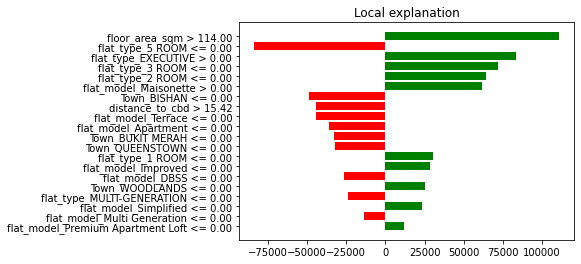

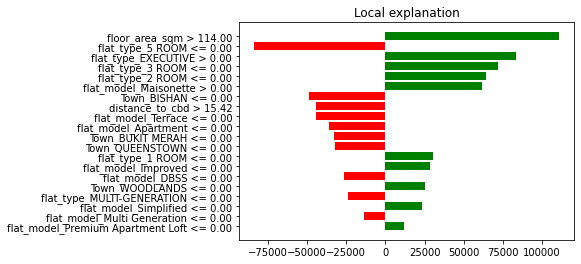

In [ ]:
exp = explainer.explain_instance(x_test.iloc[0], 
     model.predict, num_features=20)
exp.as_pyplot_figure()

In [ ]:
exp.show_in_notebook(show_table=True, show_all=False)

In [ ]:
importances = model.feature_importances_
std = np.std([model.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
feature_names=x_train.columns

Feature ranking:


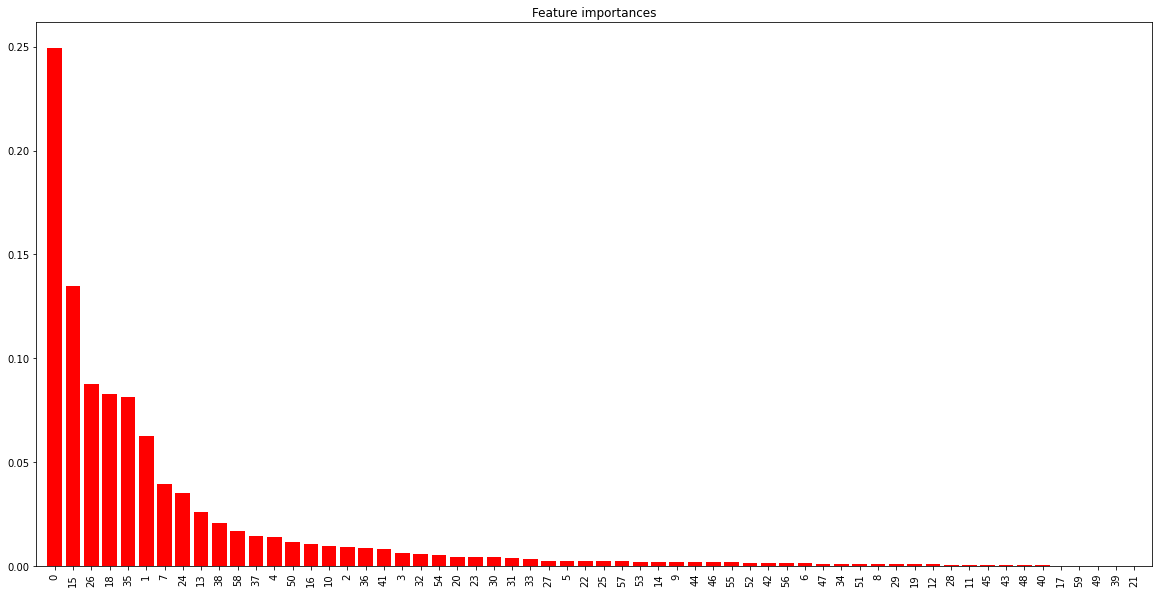

In [ ]:
print("Feature ranking:")

#for f in range(x_train.shape[1]):
    #print("feature %d (%f)" % (indices[f], importances[indices[f]]))
    #print("%s (%f)" % ([feature_names[f] , importances[indices[f]])

plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), [feature_names[i] for i in indices])
plt.xlim([-1, x_train.shape[1]])
plt.xticks(rotation=90)
plt.show()

In [ ]:
y_preds = model.predict(x_test)

In [ ]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_preds))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_preds))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_preds)))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_test, y_preds))

Mean Absolute Error: 23682.071163172073
Mean Squared Error: 1267488122.1539013
Root Mean Squared Error: 35601.79942297722


#RKF Random Forest

In [ ]:
cv_MSE_scores = []
cv_MAE_scores = []
cv_RMSLE_scores = []
cv_RMSE_scores = []
from sklearn import metrics
from sklearn.metrics import mean_squared_log_error
for train, test in rkf.split(X_final, Y_final): # try inputting interms of array 
  model=RandomForestRegressor(random_state = 42, bootstrap = False, max_depth = 90, max_features = 'sqrt', min_samples_leaf = 4,
 min_samples_split = 10,n_estimators = 600)
    #scale (No need for treebased algotirhtms)
  #scaler=MinMaxScaler()
  #scaler.fit(X_final.iloc[train])
  #Xtrain = scaler.transform(X_final.iloc[train])
  #Xtest= scaler.transform(X_final.iloc[test])
  Xtrain = X_final.iloc[train]
  Xtest= X_final.iloc[test]
  Ytrain = Y_final.iloc[train]
  Ytest = Y_final.iloc[test]
  #scaler.fit(Y_final.iloc[train])
  #Ytrain = scaler.transform(Y_final.iloc[train])

	#Fit the model
  model.fit(Xtrain, Ytrain)
    
  Ypreds = model.predict(Xtest)

  #evaluate the model
  MAE= metrics.mean_absolute_error(Ytest, Ypreds)
  MSE= metrics.mean_squared_error(Ytest, Ypreds)
  RMSE= np.sqrt(metrics.mean_squared_error(Ytest, Ypreds))
  RMSLE= np.sqrt(mean_squared_log_error( Ytest, Ypreds))

  # = model.evaluate(Xtest, scaler.transform(Y_final.iloc[test]), verbose=0)
  print("%s: %.5f" % ('mean_absolute_error', MAE))
  print("%s: %.5f" % ('mean_squared_error', MSE))
  print("%s: %.5f" % ('Root Mean Squared Error', RMSE))
  print("%s: %.5f" % ('Root Mean Squared Log Error', RMSLE))
  #print("%s: %.5f" % (model.metrics_names[4], scores[4]))
  cv_MAE_scores.append(MAE)
  cv_MSE_scores.append(MSE)
  cv_RMSE_scores.append(RMSE)
  cv_RMSLE_scores.append(RMSLE)
  #cv_MAPE_scores.append(scores[4])


print("%.5f (+/- %.5f)" % (np.mean(cv_MAE_scores), np.std(cv_MAE_scores)))
print("%.5f (+/- %.5f)" % (np.mean(cv_MSE_scores), np.std(cv_MSE_scores)))
print("%.5f (+/- %.5f)" % (np.mean(cv_RMSE_scores), np.std(cv_RMSE_scores)))
print("%.5f (+/- %.5f)" % (np.mean(cv_RMSLE_scores), np.std(cv_RMSLE_scores)))
#print("%.5f (+/- %.5f)" % (np.mean(cv_MAPE_scores), np.std(cv_MAPE_scores)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


mean_absolute_error: 23740.27565
mean_squared_error: 1267906852.38790
Root Mean Squared Error: 35607.67968
Root Mean Squared Log Error: 0.08102


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


mean_absolute_error: 23703.92976
mean_squared_error: 1267897471.95666
Root Mean Squared Error: 35607.54796
Root Mean Squared Log Error: 0.08168


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


mean_absolute_error: 23763.52584
mean_squared_error: 1272228191.12727
Root Mean Squared Error: 35668.30794
Root Mean Squared Log Error: 0.08126


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


mean_absolute_error: 23837.69113
mean_squared_error: 1278124700.13661
Root Mean Squared Error: 35750.86992
Root Mean Squared Log Error: 0.08193


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


mean_absolute_error: 23711.75630
mean_squared_error: 1271996347.65275
Root Mean Squared Error: 35665.05780
Root Mean Squared Log Error: 0.08133


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


mean_absolute_error: 23711.71383
mean_squared_error: 1262616037.07613
Root Mean Squared Error: 35533.30884
Root Mean Squared Log Error: 0.08107


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


mean_absolute_error: 23706.75304
mean_squared_error: 1265013458.27042
Root Mean Squared Error: 35567.02768
Root Mean Squared Log Error: 0.08116


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


mean_absolute_error: 23819.08786
mean_squared_error: 1283318099.13047
Root Mean Squared Error: 35823.42947
Root Mean Squared Log Error: 0.08166


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


mean_absolute_error: 23751.26254
mean_squared_error: 1270140546.97698
Root Mean Squared Error: 35639.03123
Root Mean Squared Log Error: 0.08146


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


mean_absolute_error: 23821.05313
mean_squared_error: 1287304504.31925
Root Mean Squared Error: 35879.02597
Root Mean Squared Log Error: 0.08171


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


mean_absolute_error: 23780.85244
mean_squared_error: 1269109654.21973
Root Mean Squared Error: 35624.56532
Root Mean Squared Log Error: 0.08134


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


mean_absolute_error: 23661.87360
mean_squared_error: 1251906954.48522
Root Mean Squared Error: 35382.29719
Root Mean Squared Log Error: 0.08117


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


mean_absolute_error: 23737.90174
mean_squared_error: 1263462058.04379
Root Mean Squared Error: 35545.21146
Root Mean Squared Log Error: 0.08139


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


mean_absolute_error: 23844.91329
mean_squared_error: 1285172605.19825
Root Mean Squared Error: 35849.30411
Root Mean Squared Log Error: 0.08179


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


mean_absolute_error: 23661.07381
mean_squared_error: 1261127387.45440
Root Mean Squared Error: 35512.35542
Root Mean Squared Log Error: 0.08110
23750.24426 (+/- 58.01822)
1270488324.56239 (+/- 9367457.01145)
35643.66800 (+/- 131.36239)
0.08141 (+/- 0.00028)


#XGBoost

In [ ]:
x_train, x_test, y_train, y_test= train_test_split(X_final, Y_final, test_size=0.3, random_state=42)

In [ ]:
import xgboost as xgb
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

In [ ]:
from sklearn import metrics
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_log_error
mean_train=np.mean(y_train) #Learn the mean from the training data
#baseline_predictions = np.ones(y_test.shape) * mean_train
baseline_predictions = [x * mean_train for x in np.ones(y_test.shape)]
#compute MAE
mae_baseline = mean_absolute_error(y_test, baseline_predictions)

print("baseline MAE is {:2f}". format(mae_baseline))


baseline MAE is 133162.020622


In [ ]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:linear',
}

In [ ]:
params['eval_metric'] = "mae"
num_boost_round = 999

In [ ]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

## Optimizing max_depth and min_child weight

In [ ]:
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=9, min_child_weight=5
[00:14:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 22913.0589844 for 636 rounds
CV with max_depth=9, min_child_weight=6
[01:42:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:42:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederro

## Optimizing training rate(eta)

In [ ]:
%time
# This can take some time…
min_mae = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    %time cv_results = xgb.cv(params, dtrain, num_boost_round=num_boost_round, seed=42,nfold=5, metrics=['mae'], early_stopping_rounds=10)
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
print("Best params: {}, MAE: {}".format(best_params, min_mae))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
CV with eta=0.3
[12:45:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:46:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:46:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:46:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:46:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 3h 39s, sys: 9.73 s, total: 3h 48s
Wall time: 1h 31min 41s
	MAE 23574.5156252 for 998 rounds

CV with eta=0.2
[14:17:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:17:40] WARNING: /workspace/s

In [ ]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

# Optimzing subsample and colsample

In [ ]:
min_mae = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with subsample=1.0, colsample=1.0
[12:27:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:27:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:27:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:27:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:27:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 23574.5156252 for 998 rounds
CV with subsample=1.0, colsample=0.9
[14:02:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:02:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14

In [ ]:
#best Params
params = {'colsample_bytree': 1,
 'eta': .3,
 'eval_metric': 'mae',
 'max_depth': 9,
 'min_child_weight': 7,
 'objective': 'reg:linear',
 'subsample': 1}




#Determining number of rounds

In [ ]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=999,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[10:54:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-mae:306552
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:214677
[2]	Test-mae:150503
[3]	Test-mae:105973
[4]	Test-mae:75731
[5]	Test-mae:56242.6
[6]	Test-mae:44396.4
[7]	Test-mae:37626.2
[8]	Test-mae:33921
[9]	Test-mae:31805.4
[10]	Test-mae:30618.2
[11]	Test-mae:29990.6
[12]	Test-mae:29576.2
[13]	Test-mae:29235.3
[14]	Test-mae:29067.1
[15]	Test-mae:28898.7
[16]	Test-mae:28724.5
[17]	Test-mae:28602.7
[18]	Test-mae:28531.8
[19]	Test-mae:28361.2
[20]	Test-mae:28202.1
[21]	Test-mae:28047.7
[22]	Test-mae:27935.1
[23]	Test-mae:27791.5
[24]	Test-mae:27728.7
[25]	Test-mae:27551.2
[26]	Test-mae:27503.3
[27]	Test-mae:27394.8
[28]	Test-mae:27308.5
[29]	Test-mae:27233.4
[30]	Test-mae:27146.6
[31]	Test-mae:27066.8
[32]	Test-mae:26952.9
[33]	Test-mae:26921.8
[34]	Test-mae:26787.6
[35]	Test-mae:26703
[36]	Test-mae:26623
[37]	Test-mae:26547.4
[38

In [ ]:
cv_MSE_scores = []
cv_MAE_scores = []
cv_RMSLE_scores = []
cv_RMSE_scores = []
from sklearn import metrics
from sklearn.metrics import mean_squared_log_error
for train, test in rkf.split(X_final, Y_final): # try inputting interms of array 


  Xtrain = X_final.iloc[train]
  Xtest= X_final.iloc[test]
  Ytrain = Y_final.iloc[train]
  Ytest = Y_final.iloc[test]

  dtrain = xgb.DMatrix(Xtrain, label=Ytrain)
  dtest = xgb.DMatrix(Xtest, label=Ytest)

  #model
  #xg_reg= xgb.XGBRegressor(colsample_bytree= 1, eta= .3, eval_metric= 'mae', max_depth= 9, min_child_weight= 7, objective= 'reg:linear', subsample= 1)
	#Fit the model
  #xg_reg.fit(Xtrain, Ytrain)
  model = xgb.train(
    params,
    dtrain,
    num_boost_round=660,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10)
  Ypreds = model.predict(dtest)

  #evaluate the model
  MAE= metrics.mean_absolute_error(Ytest, Ypreds)
  MSE= metrics.mean_squared_error(Ytest, Ypreds)
  RMSE= np.sqrt(metrics.mean_squared_error(Ytest, Ypreds))
  RMSLE= np.sqrt(mean_squared_log_error(Ytest, Ypreds))

  # = model.evaluate(Xtest, scaler.transform(Y_final.iloc[test]), verbose=0)
  print("%s: %.5f" % ('mean_absolute_error', MAE))
  print("%s: %.5f" % ('mean_squared_error', MSE))
  print("%s: %.5f" % ('Root Mean Squared Error', RMSE))
  print("%s: %.5f" % ('Root Mean Squared Log Error', RMSLE))
  #print("%s: %.5f" % (model.metrics_names[4], scores[4]))
  cv_MAE_scores.append(MAE)
  cv_MSE_scores.append(MSE)
  cv_RMSE_scores.append(RMSE)
  cv_RMSLE_scores.append(RMSLE)
  #cv_MAPE_scores.append(scores[4])


print("%.5f (+/- %.5f)" % (np.mean(cv_MAE_scores), np.std(cv_MAE_scores)))
print("%.5f (+/- %.5f)" % (np.mean(cv_MSE_scores), np.std(cv_MSE_scores)))
print("%.5f (+/- %.5f)" % (np.mean(cv_RMSE_scores), np.std(cv_RMSE_scores)))
print("%.5f (+/- %.5f)" % (np.mean(cv_RMSLE_scores), np.std(cv_RMSLE_scores)))
#print("%.5f (+/- %.5f)" % (np.mean(cv_MAPE_scores), np.std(cv_MAPE_scores)))

Streaming output truncated to the last 5000 lines.
[218]	Test-mae:23443.8
[219]	Test-mae:23441.8
[220]	Test-mae:23437.8
[221]	Test-mae:23438.5
[222]	Test-mae:23438.3
[223]	Test-mae:23437.5
[224]	Test-mae:23431.4
[225]	Test-mae:23428.6
[226]	Test-mae:23415.5
[227]	Test-mae:23413.6
[228]	Test-mae:23414.2
[229]	Test-mae:23407.5
[230]	Test-mae:23400.7
[231]	Test-mae:23395.7
[232]	Test-mae:23389.7
[233]	Test-mae:23387.3
[234]	Test-mae:23375.3
[235]	Test-mae:23372.4
[236]	Test-mae:23369.3
[237]	Test-mae:23369.1
[238]	Test-mae:23366.7
[239]	Test-mae:23353.3
[240]	Test-mae:23351.2
[241]	Test-mae:23346.6
[242]	Test-mae:23343.8
[243]	Test-mae:23342.2
[244]	Test-mae:23331.5
[245]	Test-mae:23328.4
[246]	Test-mae:23327
[247]	Test-mae:23324.1
[248]	Test-mae:23321.1
[249]	Test-mae:23317
[250]	Test-mae:23312.4
[251]	Test-mae:23309.6
[252]	Test-mae:23296.6
[253]	Test-mae:23291.1
[254]	Test-mae:23287.1
[255]	Test-mae:23285.8
[256]	Test-mae:23281.5
[257]	Test-mae:23278.4
[258]	Test-mae:23270
[259]	Test-m

# XGBoost Feature importance

In [ ]:
#best Params
params = {'colsample_bytree': 1,
 'eta': .3,
 'eval_metric': 'mae',
 'max_depth': 9,
 'min_child_weight': 7,
 'objective': 'reg:linear',
 'subsample': 1}

In [ ]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=660,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[05:38:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-mae:306552
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:214677
[2]	Test-mae:150503
[3]	Test-mae:105973
[4]	Test-mae:75731
[5]	Test-mae:56242.6
[6]	Test-mae:44396.4
[7]	Test-mae:37626.2
[8]	Test-mae:33921
[9]	Test-mae:31805.4
[10]	Test-mae:30618.2
[11]	Test-mae:29990.6
[12]	Test-mae:29576.2
[13]	Test-mae:29235.3
[14]	Test-mae:29067.1
[15]	Test-mae:28898.7
[16]	Test-mae:28724.5
[17]	Test-mae:28602.7
[18]	Test-mae:28531.8
[19]	Test-mae:28361.2
[20]	Test-mae:28202.1
[21]	Test-mae:28047.7
[22]	Test-mae:27935.1
[23]	Test-mae:27791.5
[24]	Test-mae:27728.7
[25]	Test-mae:27551.2
[26]	Test-mae:27503.3
[27]	Test-mae:27394.8
[28]	Test-mae:27308.5
[29]	Test-mae:27233.4
[30]	Test-mae:27146.6
[31]	Test-mae:27066.8
[32]	Test-mae:26952.9
[33]	Test-mae:26921.8
[34]	Test-mae:26787.6
[35]	Test-mae:26703
[36]	Test-mae:26623
[37]	Test-mae:26547.4
[38

<Figure size 14400x720 with 0 Axes>

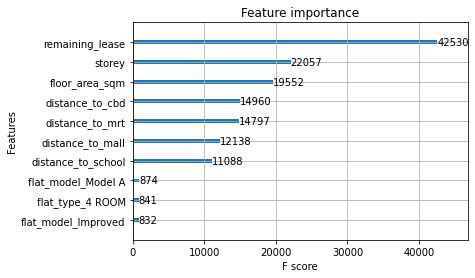

<Figure size 14400x720 with 0 Axes>

In [ ]:
from xgboost import plot_importance
plot_importance(model,max_num_features=10)

In [ ]:
import lime
import lime.lime_tabular
x_featurenames=x_train.columns
explainer = lime.lime_tabular.LimeTabularExplainer(np.array(dtrain),
                    feature_names=x_featurenames, 
                    class_names=['quality'], 
                    # categorical_features=, 
                    # There is no categorical features in this example, otherwise specify them.                               
                    verbose=True, mode='regression')


In [ ]:
feature_names=x_train.columns
def wrapped_predict(data_x):
    '''
    wrap xgboost predict function in order to make it lime-friendly
    - model and feature_names are defined outside
    '''
    
    dummy_y = np.array([ 1 for _ in range(data_x.shape[0]) ])
    tmp_data = xgb.DMatrix(data_x, dummy_y, feature_names=feature_names)
    
    tmp_out = model.predict(tmp_data)
    
    # add the first column to make it like predict_proba
    out = np.zeros((data_x.shape[0], 2))
    out[:, 0] = 1-tmp_out
    out[:, 1] = tmp_out
    
    return out

Intercept -407115.3670092267
Prediction_local [-428091.74567859]
Right: -494854.46875


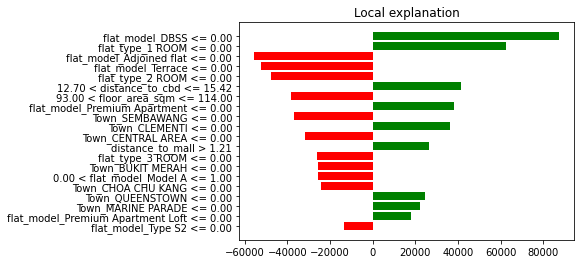

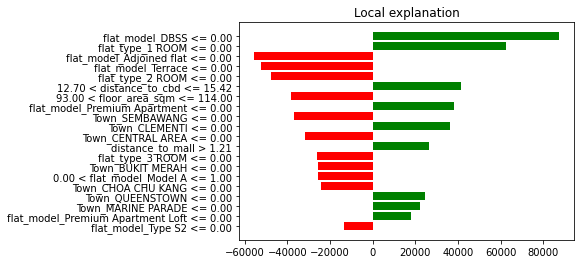

In [ ]:
exp = explainer.explain_instance(x_test.iloc[5], 
     wrapped_predict, num_features=20)
exp.as_pyplot_figure()

In [ ]:
exp.show_in_notebook(show_table=True, show_all=False)

# Neural Network + hyper parameter tuning

In [ ]:
x_train, x_test, y_train, y_test= train_test_split(X_final, Y_final, test_size=0.3, random_state=42)

In [ ]:
x_train

resale_price_adj
793695          262422.0
477967          459086.0
479493          442508.0
15755           673533.0
466625          326167.0
...                  ...
260145          421824.0
367885          237801.0
131936          418020.0
677996          295858.0
121958          457608.0

[574979 rows x 1 columns]

In [ ]:
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=998)
cv_MSE_scores = []
cv_MAE_scores = []
cv_MSLE_scores = []
cv_MAPE_scores = []
from sklearn import metrics
from sklearn.metrics import mean_squared_log_error 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
for train, test in rkf.split(X_final, Y_final): # try inoputting interms of array 
  model = Sequential()
  model.add(Dense(101, input_dim=60, activation= "relu"))
  model.add(Dense(60, activation= "relu"))
  model.add(Dense(1))
  model.summary() #Print model Summary
    #compile
  model.compile(loss= "mean_absolute_error" , optimizer="adam", metrics=["mean_squared_error","mean_absolute_error","mean_squared_logarithmic_error","MeanAbsolutePercentageError"])
    #scale
  scaler=MinMaxScaler()
  scaler.fit(X_final.iloc[train])
  Xtrain = scaler.transform(X_final.iloc[train])
  Xtest= scaler.transform(X_final.iloc[test])
  scaler.fit(Y_final.iloc[train])
  Ytrain = scaler.transform(Y_final.iloc[train])

	#Fit the model
  model.fit(Xtrain, Ytrain, epochs=50, batch_size=20, verbose=0)
  #evaluate the model
  y_results = model.predict(Xtest)
  y_results = scaler.inverse_transform(y_results)
  #scores = model.evaluate(Xtest, scaler.transform(Y_final.iloc[test]), verbose=0)
  #print("%s: %.5f" % (model.metrics_names[1], scores[1]))
  #print("%s: %.5f" % (model.metrics_names[2], scores[2]))
  #print("%s: %.5f" % (model.metrics_names[3], scores[3]))
  #print("%s: %.5f" % (model.metrics_names[4], scores[4]))
  cv_MSE_scores.append(mean_squared_error(Y_final.iloc[test], y_results ))
  cv_MAE_scores.append(mean_absolute_error(Y_final.iloc[test], y_results))
  cv_MSLE_scores.append(mean_squared_log_error(Y_final.iloc[test], abs(y_results)))
  #cv_MAPE_scores.append(mean_absolute_percentage_error(Y_final.iloc[test], y_results))
  #predict

  print('Mean Squared Error :',mean_squared_error(Y_final.iloc[test], y_results ))
  print('Mean Absolute Error :',mean_absolute_error(Y_final.iloc[test], y_results))
  print('RMSLE: ', mean_squared_log_error(Y_final.iloc[test], abs(y_results)))
  #print('MAPE: ', mean_absolute_percentage_error(Y_final.iloc[test], y_results))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 101)               6161      
_________________________________________________________________
dense_1 (Dense)              (None, 60)                6120      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 61        
Total params: 12,342
Trainable params: 12,342
Non-trainable params: 0
_________________________________________________________________
Mean Squared Error : 1583598204.6556451
Mean Absolute Error : 27057.52288772884
RMSLE:  0.008181232450097461
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 101)               6161      
_____________________________________________________

In [ ]:
df_final.columns

Index(['storey_range', 'floor_area_sqm', 'lease_commence_date', 'resale_price',
       'Year_sold', 'remaining_lease', 'Rank', 'Town_ANG MO KIO', 'Town_BEDOK',
       'Town_BISHAN', 'Town_BUKIT BATOK', 'Town_BUKIT MERAH',
       'Town_BUKIT PANJANG', 'Town_BUKIT TIMAH', 'Town_CENTRAL AREA',
       'Town_CHOA CHU KANG', 'Town_CLEMENTI', 'Town_GEYLANG', 'Town_HOUGANG',
       'Town_JURONG EAST', 'Town_JURONG WEST', 'Town_KALLANG/WHAMPOA',
       'Town_LIM CHU KANG', 'Town_MARINE PARADE', 'Town_PASIR RIS',
       'Town_PUNGGOL', 'Town_QUEENSTOWN', 'Town_SEMBAWANG', 'Town_SENGKANG',
       'Town_SERANGOON', 'Town_TAMPINES', 'Town_TOA PAYOH', 'Town_WOODLANDS',
       'Town_YISHUN', 'flat_type_1 ROOM', 'flat_type_2 ROOM',
       'flat_type_3 ROOM', 'flat_type_4 ROOM', 'flat_type_5 ROOM',
       'flat_type_EXECUTIVE', 'flat_type_MULTI-GENERATION',
       'flat_model_2-room', 'flat_model_Adjoined flat', 'flat_model_Apartment',
       'flat_model_DBSS', 'flat_model_Improved',
       'flat_model

In [ ]:
# split into input (X) and output (Y) variables
y_list =['resale_price']
x_list =[x for x in df_final.columns if x not in y_list]
X = df_final[x_list]
Y = df_final[y_list]

In [ ]:
print(X.head())
print(Y.head())

   storey_range  floor_area_sqm  ...  flat_model_Type S1  flat_model_Type S2
0           4.0            31.0  ...                   0                   0
1           2.0            31.0  ...                   0                   0
2           4.0            31.0  ...                   0                   0
3           3.0            31.0  ...                   0                   0
4           2.0            73.0  ...                   0                   0

[5 rows x 60 columns]
   resale_price
0        9000.0
1        6000.0
2        8000.0
3        6000.0
4       47200.0


## Modelling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor

In [ ]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X_final= scaler.fit_transform(X)
Y_final= scaler.fit_transform(Y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_final, Y_final)

In [ ]:
print(X_train.shape)
print(y_train)

(507835, 60)
[[0.21506764]
 [0.10920945]
 [0.61532192]
 ...
 [0.14262429]
 [0.16462918]
 [0.36837816]]


In [ ]:
# Define model
model = Sequential()
model.add(Dense(101, input_dim=60, activation= "relu"))
model.add(Dense(60, activation= "relu"))
model.add(Dense(1))
model.summary() #Print model Summary


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 101)               6161      
_________________________________________________________________
dense_1 (Dense)              (None, 60)                6120      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 61        
Total params: 12,342
Trainable params: 12,342
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error","mean_absolute_error","mean_squared_logarithmic_error"])

In [ ]:
history = model.fit(X_train, y_train, epochs=50,validation_split=0.2,batch_size=20, verbose=1) # change larger batch size.

Epoch 1/50
20314/20314 [==============================] - 34s 2ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0248 - mean_squared_logarithmic_error: 7.2253e-04 - val_loss: 7.0964e-04 - val_mean_squared_error: 7.0964e-04 - val_mean_absolute_error: 0.0192 - val_mean_squared_logarithmic_error: 4.2022e-04
Epoch 2/50
20314/20314 [==============================] - 33s 2ms/step - loss: 6.9120e-04 - mean_squared_error: 6.9120e-04 - mean_absolute_error: 0.0190 - mean_squared_logarithmic_error: 4.0968e-04 - val_loss: 6.4168e-04 - val_mean_squared_error: 6.4168e-04 - val_mean_absolute_error: 0.0185 - val_mean_squared_logarithmic_error: 3.8135e-04
Epoch 3/50
20314/20314 [==============================] - 36s 2ms/step - loss: 6.4484e-04 - mean_squared_error: 6.4484e-04 - mean_absolute_error: 0.0183 - mean_squared_logarithmic_error: 3.8211e-04 - val_loss: 6.4540e-04 - val_mean_squared_error: 6.4540e-04 - val_mean_absolute_error: 0.0184 - val_mean_squared_logarithmic_err

In [ ]:
print(history.history.keys()) # calculate change over iterations (diminishing returns)
# summarize history for accuracy
#plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
#plt.title('model accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
#plt.show()
# summarize history for loss
plt.figure(figsize=(14,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#summarize history for RMSE
plt.figure(figsize=(14,8))
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#summarize history for RMSLE
plt.figure(figsize=(14,8))
plt.plot(history.history['mean_squared_logarithmic_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model RMSLE')
plt.ylabel('RMSLE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#summarize history for MAE
plt.figure(figsize=(14,8))
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


NameError: ignored

## Validation

In [ ]:
y_test_nn = model.predict(X_test)


In [ ]:
y_test_nn_inv=scaler.inverse_transform(y_test_nn)
y_test_inv=scaler.inverse_transform(y_test)

In [ ]:
y_test_nn_inv_abs=abs(y_test_nn_inv)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_log_error
from math import sqrt
#(y_test_inv,y_test_nn_final)
print('Mean Squared Error :',mean_squared_error(y_test_inv, y_test_nn_inv ))
print('Mean Absolute Error :',mean_absolute_error(y_test_inv, y_test_nn_inv))
#print('R^2 :',r2_score(y_test_inv, y_test_nn_inv))
print('RMSLE: ', mean_squared_log_error(y_test_inv, y_test_nn_inv_abs))

Mean Squared Error : 765755587.3414464
Mean Absolute Error : 19663.98883872441
RMSLE:  0.013326804904250443


In [ ]:
#print('Mean Squared Error :',mean_squared_error(y_test, ))
#print('Mean Absolute Error :',mean_absolute_error(y_test, y_pred_xgb))
#print('R^2 :',r2_score(y_test, y_pred_xgb))
#print('RMSLE: ', mean_squared_log_error(y_test, y_pred_xgb))

In [ ]:
X_test_inv

NameError: ignored

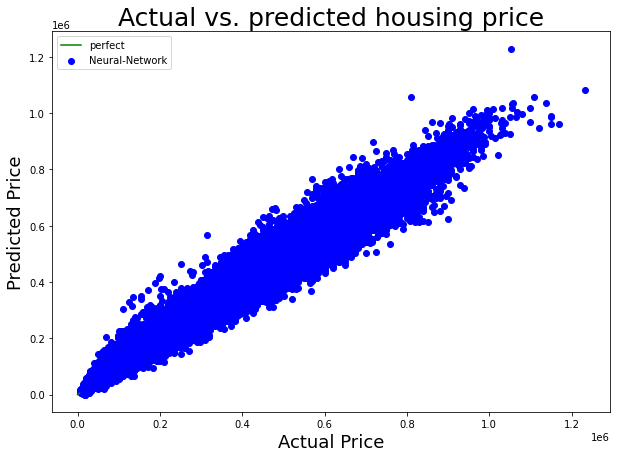

In [ ]:
plt.figure(figsize=(10,7))
plt.title("Actual vs. predicted housing price",fontsize=25)
plt.xlabel("Actual Price",fontsize=18)
plt.ylabel("Predicted Price", fontsize=18)
plt.scatter(x=y_test_inv,y=y_test_nn_inv, c='b', label='Neural-Network')
plt.plot([0,5000], [0,5000], '-g', label='perfect')
plt.legend(loc='upper left')
plt.show()



# model Explanation: shapley value

In [ ]:
pip install shap

     |████████████████████████████████| 327kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.36.0-cp36-cp36m-linux_x86_64.whl size=456454 sha256=7aeaa3ba275000823486fa94a70a8887f221d361814c6d22278fdf658fec9ee3
  Stored in directory: /root/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
Successfully built shap


In [ ]:
import shap
#import tf.keras.backend 
background = X_train[np.random.choice( X_train.shape[0], 100, replace=False)]# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(model,  background)

ModuleNotFoundError: ignored

In [ ]:
shap.initjs()
shap_values = explainer.shap_values(X_train)
shap.force_plot(explainer.expected_value[0].numpy(),shap_values[0][0,:],X_test[0,:])

NameError: ignored

In [ ]:
shap.summary_plot(shap_values[0], X_train)

In [ ]:
shap.summary_plot(shap_values, X)

In [ ]:
#!pip install shap
import shap

# load JS visualization code to notebook
#shap.initjs()
#explainer = shap.TreeExplainer(model)
#shap_values = explainer.shap_values(X)


# select a set of background examples to take an expectation over
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

# explain predictions of the model on three images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(X_test[1:10])

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


keras is no longer supported, please use tf.keras instead.


In [ ]:
i = 4
shap.force_plot(explainer.expected_value, shap_values[i], features=X.iloc[i], feature_names=X.columns)

In [ ]:
!pip install shap
!pip install lime
!pip install eli5
